In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import sys
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import softmax
from scipy.stats import pearsonr
import time
import os
import torchvision
import torchvision.transforms as transforms

#from models.conv_iResNet import conv_iResNet as iResNet

In [7]:
ckpt = torch.load('results/checkpoint.t7')
model = ckpt['model'].module

In [18]:
device = torch.device("cuda:0")
model.to(device)
model.eval()

conv_iResNet(
  (init_squeeze): squeeze()
  (inj_pad): injective_pad(
    (pad): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
  )
  (stack): ModuleList(
    (0): conv_iresnet_block(
      (squeeze): squeeze()
      (bottleneck_block): Sequential(
        (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (3): ELU(alpha=1.0)
        (4): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (actnorm): ActNorm2D()
    )
    (1): conv_iresnet_block(
      (squeeze): squeeze()
      (bottleneck_block): Sequential(
        (0): ELU(alpha=1.0)
        (1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): ELU(alpha=1.0)
        (3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        (4): ELU(alpha=1.0)
        (5): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (actnorm): ActNorm2D()

In [9]:
clf_chain = [transforms.Normalize(
    (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
test_chain = [transforms.ToTensor()]
transform_test = transforms.Compose(test_chain + clf_chain)
testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16,
    shuffle=False, num_workers=2, worker_init_fn=np.random.seed(1234))

Files already downloaded and verified


In [19]:
x,y = next(iter(testloader))
x = x.to(device)
y = y.to(device)
x.shape, y.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [46]:
logits, z = model(x)
print(logits.shape, z.shape)

torch.Size([16, 10]) torch.Size([16, 192, 4, 4])


In [47]:
print(y)
print(logits.argmax(1))

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8], device='cuda:0')
tensor([5, 8, 8, 0, 6, 6, 1, 2, 3, 1, 0, 9, 4, 7, 9, 8], device='cuda:0')


In [48]:
out = model.inverse(z)

In [25]:
out.shape

torch.Size([16, 3, 32, 32])

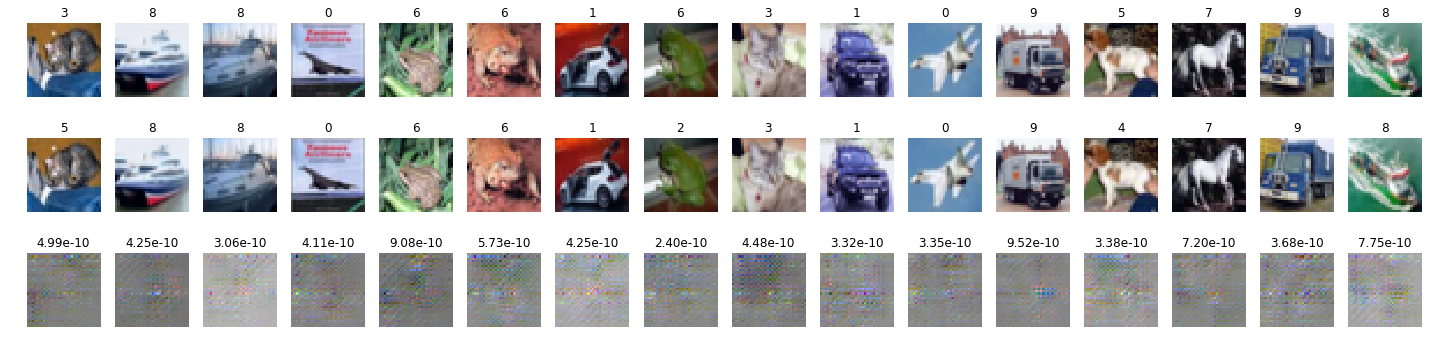

In [39]:
plt.figure(figsize=(25,6))
for i in range(16):
    plt.subplot(3, 16, i+1)
    plt.title(y[i].item())
    tmp = np.transpose(x[i].cpu(), [1,2,0]).numpy().copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')
    plt.subplot(3, 16, i+17)
    plt.title(logits.argmax(1)[i].item())
    tmp = np.transpose(out[i].cpu(), [1,2,0]).numpy().copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')
    plt.subplot(3, 16, i+33)
    tmp = np.transpose(out[i].cpu(), [1,2,0]).numpy().copy() -\
        np.transpose(x[i].cpu(), [1,2,0]).numpy().copy()
    plt.title('%.2e' % np.mean(tmp**2))
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')

In [49]:
# interpolate
z_inter = torch.zeros_like(z)
for i, alpha in enumerate(np.linspace(0, 1, 16)):
    z_inter[i] = (1 - alpha) * z[1] + alpha * z[2]

In [50]:
out = model.inverse(z_inter)

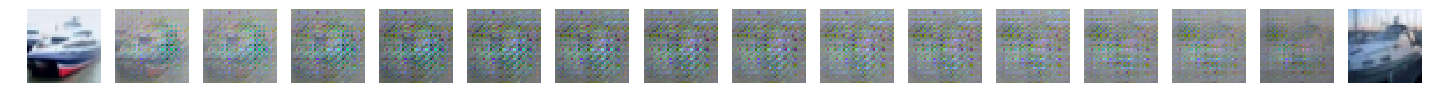

In [51]:
plt.figure(figsize=(25,2))
for i in range(16):
    plt.subplot(1, 16, i+1)
    tmp = np.transpose(out[i].cpu(), [1,2,0]).numpy().copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')

In [78]:
# rewrite annotations in expected format
with open('ucfTrainTestlist/trainlist01.txt','r') as f:
    listed = list(f)
with open('ucfTrainTestlist/reformatted/trainlist01.txt','w') as f:
    f.writelines([l.split('/')[1] for l in listed])

In [90]:
ucf101 = torchvision.datasets.UCF101(
    root='/gpfs01/bethge/data/ucf101/',
    annotation_path='ucfTrainTestlist/reformatted/',
    frames_per_clip=16,
    step_between_clips=8,
    fold=1,
    train=True,
    transform=None,)

0it [00:00, ?it/s]


In [91]:
dir(ucf101)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_format_transform_repr',
 '_repr_indent',
 '_select_fold',
 'classes',
 'extra_repr',
 'fold',
 'indices',
 'root',
 'samples',
 'target_transform',
 'train',
 'transform',
 'transforms',
 'video_clips']

In [92]:
ucf101.samples, ucf101.classes, ucf101.indices, ucf101.video_clips

([], [], [], <torchvision.datasets.video_utils.VideoClips at 0x7f2795c53e48>)

In [83]:
dir(ucf101.video_clips)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_compute_frame_pts',
 '_init_from_metadata',
 '_resample_video_idx',
 'clips',
 'compute_clips',
 'compute_clips_for_video',
 'cumulative_sizes',
 'frame_rate',
 'get_clip',
 'get_clip_location',
 'num_clips',
 'num_frames',
 'num_videos',
 'resampling_idxs',
 'step',
 'subset',
 'video_fps',
 'video_paths',
 'video_pts']

In [87]:
ucf101.video_clips.num_clips()

IndexError: list index out of range

In [65]:
ucfloader = torch.utils.data.DataLoader(
    ucf101, batch_size=16,
    shuffle=False, num_workers=2, worker_init_fn=np.random.seed(1234))

x,y = next(iter(ucfloader))
x = x.to(device)
y = y.to(device)
x.shape, y.shape

IndexError: list index out of range

In [263]:
import os

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset


class GeneralVideoDataset(Dataset):
    """Dataset Class for Loading Video"""

    def __init__(
        self,
        root_dir,
        channels=3,
        time_depth=16,
        step_size=1,
        x_size=32,
        y_size=32,
        mean=None,
        transform=None,
    ):
        """
        Args:
            clips_list_file (string): Path to the clipsList file with labels.
            root_dir (string): Directory with all the videoes.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            channels: Number of channels of frames
            time_depth: Number of frames to be loaded in a sample
            x_size, y_size: Dimensions of the frames
            mean: Mean value of the training set videos over each channel
        """

        self.clips_list = [f for f in os.listdir(root_dir) if f.endswith('.avi')]
        self.root_dir = root_dir
        self.channels = channels
        self.time_depth = time_depth
        self.x_size = x_size
        self.y_size = y_size
        self.mean = mean
        self.transform = transform
        self.step_size = step_size

    def __len__(self):
        return len(self.clips_list)

    def read_video(self, video_file):
        # Open the video file
        print(video_file)
        cap = cv2.VideoCapture(video_file)
        frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frameCount < self.time_depth * self.step_size:
            print('too short')
            return None, True
        frames = torch.FloatTensor(
            self.channels, self.time_depth, self.x_size, self.y_size
        )
        failed_clip = False
        ind = 0
        f = 0
        while True:
            ret, frame = cap.read()
            if not(f % self.step_size):
                frame = cv2.resize(frame, (self.x_size, self.y_size))
                if ret:
                    frame = torch.from_numpy(frame)
                    # HWC2CHW
                    frame = frame.permute(2, 0, 1)
                    frames[:, ind, :, :] = frame
                else:
                    print("Can't read")
                    failed_clip = True
                    break
                ind += 1
                if ind == self.time_depth:
                    break
            f += 1
        cap.release()

        #for idx in range(len(self.mean)):
        #    frames[idx] = (frames[idx] - self.mean[idx]) / self.stddev[idx]

        return frames, failed_clip

    def __getitem__(self, idx):

        while True:
            video_file = os.path.join(self.root_dir, self.clips_list[idx])
            clip, failed_clip = self.read_video(video_file)
            if not failed_clip:
                break
            else:
                idx += 1
        if self.transform:
            clip = self.transform(clip)
        sample = {
            "clip": clip,
            "label": self.clips_list[idx][1],
            "failedClip": failed_clip,
        }

        return sample

In [286]:
from models.ucf101_loader import UCF101

In [287]:
ucf101 = UCF101('/gpfs01/bethge/data/ucf101/',
        time_depth=2, step_size=5)

In [288]:
len(ucf101.clips_list)

13320

In [289]:
ucfloader = torch.utils.data.DataLoader(
    ucf101, batch_size=16, shuffle=True, num_workers=0)

x = next(iter(ucfloader))
#x = x.to(device)
#y = y.to(device)
#x.shape, y.shape

In [290]:
x['clip'].shape

torch.Size([16, 2, 3, 32, 32])

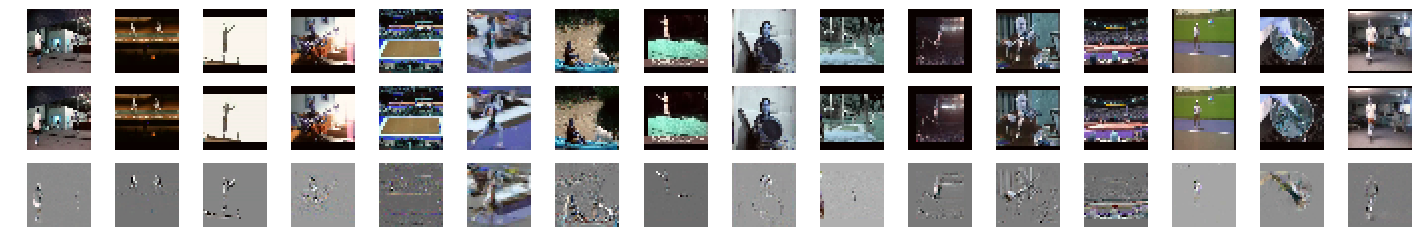

In [291]:
plt.figure(figsize=(25,4))
for i in range(16):
    plt.subplot(3, 16, i+1)
    tmp = np.transpose(x['clip'][i,0].cpu(), [1,2,0]).numpy().copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')
    plt.subplot(3, 16, i+17)
    tmp = np.transpose(x['clip'][i,1].cpu(), [1,2,0]).numpy().copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')
    plt.subplot(3, 16, i+33)
    tmp = np.transpose(x['clip'][i,1].cpu(), [1,2,0]).numpy().copy() -\
        np.transpose(x['clip'][i,0].cpu(), [1,2,0]).numpy().copy()
    tmp -= np.min(tmp)
    tmp /= np.max(tmp)
    plt.imshow(tmp)
    plt.axis('off')

In [292]:
x['clip'].mean((0,2,3,4)), x['clip'].std((0,2,3,4))

(tensor([-0.1216, -0.1310]), tensor([1.0615, 1.0529]))